In [3]:
!pip install kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d emineyetm/fake-news-detection-datasets

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.10/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [5]:
!unzip /content/fake-news-detection-datasets.zip

unzip:  cannot find or open /content/fake-news-detection-datasets.zip, /content/fake-news-detection-datasets.zip.zip or /content/fake-news-detection-datasets.zip.ZIP.


# **Import necessary libraries**

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

# **Load the data**

In [7]:
true_df = pd.read_csv("/kaggle/input/fake-news-classification/True.csv")

# **preprocessing**

In [8]:
#replace all the labels with real

true_df['subject'] = true_df['subject'].replace({'politicsNews':'real','worldnews':'real'})

In [9]:
true_df['subject'].value_counts()

subject
real    21417
Name: count, dtype: int64

In [10]:
#read the fake news

fake_df = pd.read_csv("/kaggle/input/fake-news-classification/Fake.csv")

In [11]:
#available categories in fake news set

fake_df['subject'].value_counts().index

Index(['News', 'politics', 'left-news', 'Government News', 'US_News',
       'Middle-east'],
      dtype='object', name='subject')

In [12]:
#replace all the category with fake

fake_df['subject'] = fake_df['subject'].replace({'News':'fake','politics':"fake","left-news":"fake","Government News":"fake","US_News":"fake","Middle-east":"fake"})

In [13]:
fake_df['subject'].value_counts()

subject
fake    23481
Name: count, dtype: int64

In [14]:
#concate real news set and fake news set and shuffle randomly

combined_df = pd.concat([true_df,fake_df])
new_df = combined_df.sample(frac=1).reset_index(drop=True)

In [15]:
#overview of the dataset

new_df.head()

,title,text,subject,date
0,Trump discusses safe zones in Syria with Jorda...,WASHINGTON (Reuters) - U.S. President Donald T...,real,"February 2, 2017"
1,Corporate winners of Obama budget still face l...,NEW YORK (Reuters) - Facing a hostile Congress...,real,"February 8, 2016"
2,We May Already Have More Than Half The Republ...,There are several movements out there to try a...,fake,"December 14, 2016"
3,Saudi Arabia suspends any dialogue with Qatar:...,DUBAI (Reuters) - Saudi Arabia on Saturday sus...,real,"September 8, 2017"
4,Factbox: A look at U.S. healthcare spending as...,NEW YORK (Reuters) - U.S. President Donald Tru...,real,"March 23, 2017"


In [16]:
# Drop unused column

new_df.drop(['date'],axis=1,inplace=True)

# **Format new dataset**

In [17]:
# create a new column

new_df['news'] = new_df['title'] + ' ' +new_df['text']

In [18]:
new_df.drop(['title','text'],inplace=True,axis=1)

In [19]:
new_df['subject'].value_counts()

subject
fake    23481
real    21417
Name: count, dtype: int64

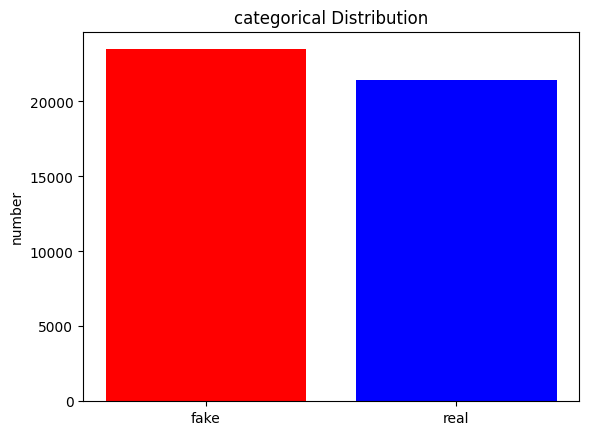

In [20]:
# check the balanceness of the label through visualization
import matplotlib.pyplot as plt
index = new_df['subject'].value_counts().index
value = new_df['subject'].value_counts().values

# plot the categorical distribution

plt.bar(index,value,color=['r','b'])
plt.title("categorical Distribution")
plt.ylabel("number")
plt.show()

# **Tfidf vectorization**

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(stop_words="english",max_features=15000)
X = tf.fit_transform(new_df['news']).toarray()

# **Encoding label from categorical to numeric**

In [22]:
from sklearn.preprocessing import LabelEncoder # using labelencoding method
lbl = LabelEncoder()
new_df['subject'] = lbl.fit_transform(new_df['subject'])

# **separate target and feature**

In [23]:
import numpy as  np
X = np.array(X)
y = np.array(new_df['subject'])

# **split train and test set**

In [24]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

# **Time to shift in DL model**

In [25]:
#import necessary libraries under tenforflow framework

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM,GRU,Bidirectional,Embedding,Dense,Dropout
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras import Sequential

# **text Preprocessing**

In [26]:
import re

def clean_text(text):
    # Remove punctuation, symbols, and hyperlinks
    clean_text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and symbols
    clean_text = re.sub(r'http\S+', '', clean_text)  # Remove hyperlinks
    clean_text = clean_text.lower()  # Convert to lowercase
    return clean_text

new_df['news'] = new_df['news'].apply(clean_text)


In [27]:
#over view

new_df['news']

0        trump discusses safe zones in syria with jorda...
1        corporate winners of obama budget still face l...
2         we may already have more than half the republ...
3        saudi arabia suspends any dialogue with qatar ...
4        factbox a look at us healthcare spending as ob...
                               ...                        
44893    pope urges decisive measures for myanmar refug...
44894    fbi files revealed valerie jarretts family tie...
44895    trump offers us support to french president af...
44896    support for nzs labour party improves position...
44897     watch everybody laughed after watching this b...
Name: news, Length: 44898, dtype: object

# **Tokenization**

In [28]:
tk = Tokenizer()  #initialize the tokenizer

tk.fit_on_texts(new_df['news'])
seq = tk.texts_to_sequences(new_df['news'])

In [29]:
# convert into vector where each vector size will be 200
vector = pad_sequences(seq,padding='post',maxlen=200)

# **convert feature vector and label into numpy array **

In [30]:
X = np.array(vector)
y = np.array(new_df['subject'])

# **split train and test set**

In [31]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

# **Design the model using LSTM architecture**

In [32]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=len(tk.word_index)+1,output_dim=200,input_length=200))
model_lstm.add(LSTM(units=128))
model_lstm.add(Dense(units=1,activation='sigmoid'))

In [33]:
#model compilation

model_lstm.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [34]:
# train the model with 2 epochs only
history = model_lstm.fit(x_train,y_train,epochs=2,validation_data=(x_test,y_test),batch_size=16)

Epoch 1/2
2245/2245 [==============================] - 1953s 869ms/step - loss: 0.1986 - accuracy: 0.9206 - val_loss: 0.0967 - val_accuracy: 0.9666
Epoch 2/2
2245/2245 [==============================] - 1886s 840ms/step - loss: 0.0404 - accuracy: 0.9872 - val_loss: 0.0293 - val_accuracy: 0.9914


In [35]:
#evaluate the model
model_lstm.evaluate(x_test,y_test)

281/281 [==============================] - 23s 81ms/step - loss: 0.0293 - accuracy: 0.9914


[0.029253633692860603, 0.9914253950119019]

In [36]:
# Save the model to your desktop directory
#model_lstm.save('C:/Users/DELL/Downloads/fake-news-detector.h5')

In [37]:
from keras.models import load_model
#saved_model = load_model("/content/News _dataset/fake-news-detector")

In [38]:
y_pred_prob = model_lstm.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

281/281 [==============================] - 23s 81ms/step


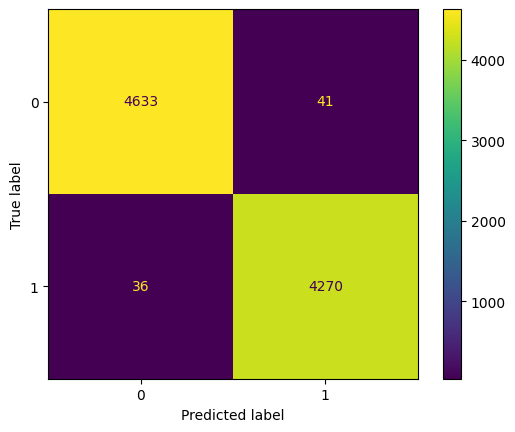

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
cnf = confusion_matrix(y_test,y_pred)
ax = ConfusionMatrixDisplay(cnf).plot()
plt.show()

# **Using Gatted Recurrent Unit**

In [40]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=len(tk.word_index)+1,output_dim=200,input_length=200))
model_gru.add(GRU(units=128))
model_gru.add(Dense(units=1,activation='sigmoid'))

In [41]:
model_gru.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model_gru.fit(x_train,y_train,epochs=2,validation_data=(x_test,y_test),batch_size=16)

Epoch 1/2
2245/2245 [==============================] - 1777s 791ms/step - loss: 0.1497 - accuracy: 0.9395 - val_loss: 0.0350 - val_accuracy: 0.9890
Epoch 2/2
 552/2245 [======>.......................] - ETA: 22:33 - loss: 0.0114 - accuracy: 0.9964

In [ ]:
y_pred_prob_gru = model_gru.predict(x_test)
y_pred_gru = (y_pred_prob_gru > 0.5).astype(int)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
cnf_gru = confusion_matrix(y_test,y_pred_gru)
ax_gru = ConfusionMatrixDisplay(cnf_gru).plot()
plt.show()

#**Using** **BiLSTM**

In [ ]:
model_bi = Sequential()
model_bi.add(Embedding(input_dim=len(tk.word_index)+1,output_dim=200,input_length=200))
model_bi.add(Bidirectional(LSTM(units=128)))
model_bi.add(Dense(units=1,activation='sigmoid'))

In [ ]:
model_bi.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model_bi.fit(x_train,y_train,epochs=2,validation_data=(x_test,y_test),batch_size=16)

In [ ]:
y_pred_prob_bi = model_bi.predict(x_test)
y_pred_bi = (y_pred_prob_bi > 0.5).astype(int)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
#performance report
print(f"classification report:\n{classification_report(y_test,y_pred_bi)}")

cnf_bi = confusion_matrix(y_test,y_pred_bi)
ax_bi = ConfusionMatrixDisplay(cnf_bi).plot()
plt.show()